# Summary

1. Dimensionality reduction of data through PCA
2. (AR)HMM to quantify dynamics of (dim-reduced) activity

In [1]:
import sys
sys.path.insert(0, '../flygenvectors/')

import os
import numpy as np
from glob import glob
import scipy.io as sio
from scipy import sparse, signal

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import data as dataUtils
import plotting
import utils

from ssm import HMM
from ssm.util import rle
from ssm.primitives import hmm_sample, lds_sample
from ssm.observations import GaussianObservations
from ssm.init_state_distns import InitialStateDistribution
from ssm.preprocessing import trend_filter

In [2]:
sns.set_style("white")
sns.set_context("talk")

### load data

In [3]:
exp_date = '2019_07_01'
fly_num = 'fly2'
main_dir = '/Users/evan/Dropbox/_AxelLab/_flygenvectors_dataShare/'

exp_folder = exp_date + '_' + fly_num + '/'
file_name_main = exp_date + '*' + fly_num + '.npz'
file_name_A = exp_date + '*' + fly_num + '_A.npz'

file_path_main = glob(main_dir+exp_folder+file_name_main)[0]
# file_path_main = os.path.join(main_dir, exp_folder, file_name_main)
mat_contents = np.load(file_path_main)
# file_path_A = os.path.join(main_dir, exp_folder, file_name_A)
file_path_A = glob(main_dir+exp_folder+file_name_A)[0]
A = sparse.load_npz(file_path_A)

# trialFlag: indexes running/feeding/running components of the experiment
# dOO: ratiometric dF/F for every active cell
# A: spatial footprint of these cells
# ball, dlc: behavioral data

### preprocess data - split into training/testing sets

In [4]:
# get data from matlab dict
behavior = np.squeeze(mat_contents['ball'])
dlc_behav = np.squeeze(mat_contents['dlc'])
time = np.squeeze(mat_contents['time'])
dFF = np.squeeze(mat_contents['dFF'])
dims = np.squeeze(mat_contents['dims'])


### remove cells with probable motion artifacts

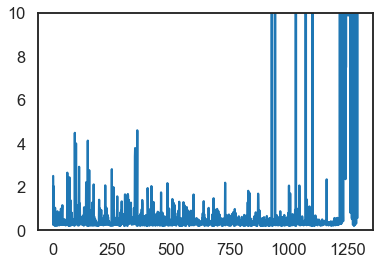

In [5]:
motionThreshold = 10 # signal this large is probably artifact
mx = np.amax(dFF,axis=1)
plt.figure
plt.plot(mx)
plt.ylim(0,motionThreshold)
motionFlag = mx<motionThreshold
dFF = dFF[motionFlag,:]
A = A[:,motionFlag]

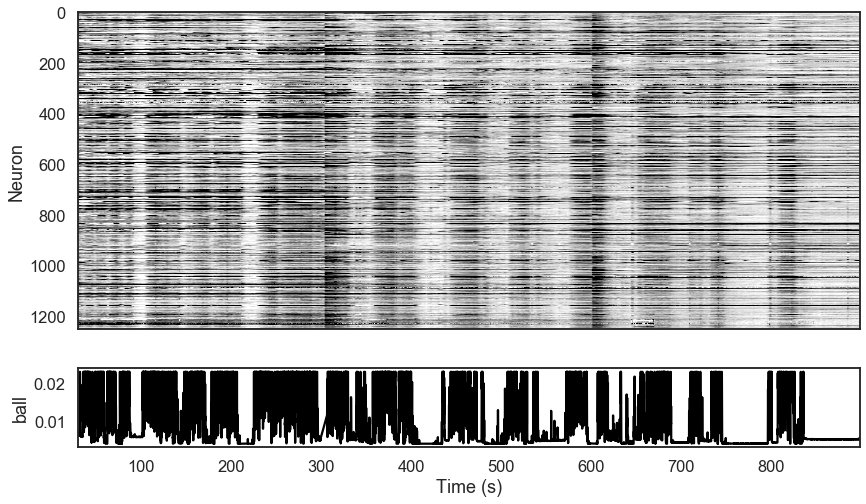

In [65]:
# preprocess
bmin = np.quantile(behavior, 0.1)
bmax = np.quantile(behavior, 0.9)
behavior[behavior<bmin]=bmin
behavior[behavior>bmax]=bmax

# data_run = zscore(dFF)
# data_run = signal.detrend(data_run, axis=0)
dFFc = dFF #dataUtils.cluster(dFF)

vmin = np.quantile(dFFc, 0.01)
vmax = np.quantile(dFFc, 0.95)
dFFc[dFFc<vmin]=vmin
dFFc[dFFc>vmax]=vmax

# plt.figure(figsize=(12, 12))
f, (a0,a1) = plt.subplots(2,1,gridspec_kw={'height_ratios':[4,1]},figsize=(14, 8))
#f.set_figsize([12,12])
#plt.subplot(121)



a0.imshow(
    dFF, aspect='auto', 
    cmap='Greys', vmin=vmin, vmax=vmax)
plt.sca(a0)
a0.set_xlim([0,len(behavior)])
plt.xticks([])
plt.ylabel('Neuron')


plt.sca(a1)
a1.plot(time,behavior,'k')
a1.set_xlim([min(time),max(time)])
a1.set_ylabel('ball')
plt.xlabel('Time (s)')
plt.show()

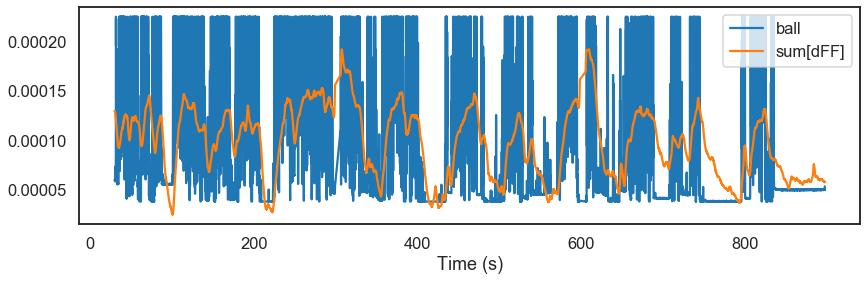

In [73]:
# summed neural data lags behind behavioral data, but derivative is aligned in time
dFFsum = np.sum(dFF,axis=0)/np.sum(dFF)
plt.figure(figsize=(14, 4))
plt.plot(time, behavior/np.sum(behavior))
plt.plot(time, dFFsum)
plt.xlabel('Time (s)')
plt.legend(('ball','sum[dFF]'))
plt.show()

In [25]:
# split into train/test trials
print(np.shape(dFFc))
data_run = np.transpose(dFFc)
trial_len = 1000  # length of pseudo-trialsl
n_trials = np.floor(data_run.shape[0] / trial_len)
indxs = utils.split_trials(
    n_trials, trials_tr=8, trials_val=2, trials_test=0, trials_gap=0)
data = {}
run = {}
for dtype in ['train', 'test', 'val']:
    data_segs = []
    run_segs = []
    for indx in indxs[dtype]:
        data_segs.append(data_run[(indx*trial_len):(indx*trial_len + trial_len)])
        run_segs.append(behavior[(indx*trial_len):(indx*trial_len + trial_len)])
    data[dtype] = data_segs
    run[dtype] = run_segs
# for PCA/regression
data['train_all'] = np.concatenate(data['train'], axis=0)
data['val_all'] = np.concatenate(data['val'], axis=0)
run['train_all'] = np.concatenate(run['train'], axis=0)
run['val_all'] = np.concatenate(run['val'], axis=0)

(1249, 10293)


In [26]:
# data_run_dt = signal.detrend(np.copy(data_run), axis=0)

In [27]:
# slc = (0, 5000)
# vmin = np.quantile(data_run[slice(*slc)], 0.01)
# vmax = np.quantile(data_run[slice(*slc)], 0.99)
# plt.figure(figsize=(12, 20))
# plt.imshow(
#     data_run[slice(*slc), :].T - data_run_dt[slice(*slc), :].T, aspect='auto', 
#     cmap='Greys', vmin=vmin, vmax=vmax)
# plt.xlim(0, slc[1] - slc[0])
# plt.xlabel('Time')
# plt.ylabel('Neuron')
# plt.show()

In [28]:
# n_rows = 6
# n_cols = 3
# ns = np.argsort(np.mean(np.square(data_run - data_run_dt), axis=0))[-(n_rows*n_cols):]
# plt.figure(figsize=(12, 12))
# for i, n in enumerate(ns):
#     plt.subplot(n_rows, n_cols, i+1)
#     plt.plot(data_run[slice(*slc), n], label='original')
#     plt.plot(data_run_dt[slice(*slc), n], label='detrended')
#     plt.title('Cell %03i' % n, fontsize=10)
#     if i != 4 or i != 5:
#         plt.xticks([])
# plt.legend(frameon=False, fontsize=10)
# plt.show()

# 1. Dimensionality reduction through PCA

In [29]:
pca = PCA(n_components=2)
pca.fit(data['train_all'])
proj = pca.transform(data_run)

### visualize in 2D

(10293,)
(10293, 2)


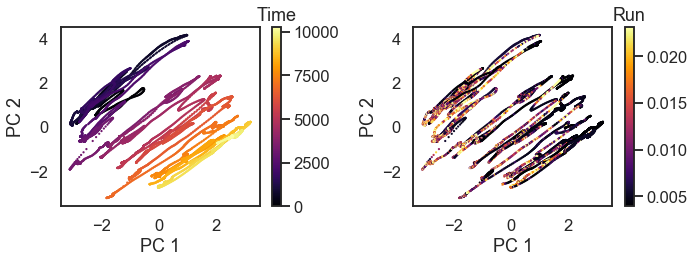

In [30]:

plt.figure(figsize=(10, 4))

pca2 = PCA(n_components=2)
pca2.fit(np.transpose(dFFc))
proj2 = pca2.transform(np.transpose(dFFc))
  
print(np.shape(behavior))
print(np.shape(proj2))

# color PCs by time
plt.subplot(121)
plotting.plot_pcs(proj2, color=np.arange(proj2.shape[0]))
cbar = plt.colorbar()
cbar.ax.set_title('Time')

# color PCs by running speed
plt.subplot(122)
plotting.plot_pcs(proj2, color=behavior)
cbar = plt.colorbar()
cbar.ax.set_title('Run')
plt.tight_layout()
plt.show()

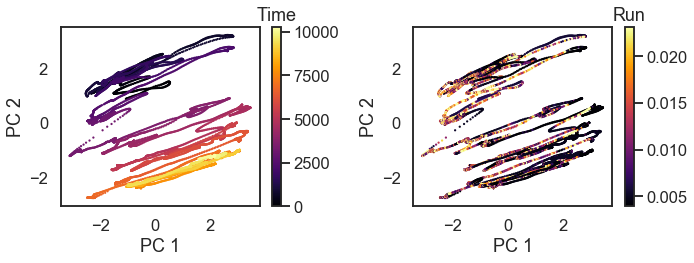

In [31]:
plt.figure(figsize=(10, 4))
    
# color PCs by time
plt.subplot(121)
plotting.plot_pcs(proj, color=np.arange(proj.shape[0]))
cbar = plt.colorbar()
cbar.ax.set_title('Time')

# color PCs by running speed
plt.subplot(122)
plotting.plot_pcs(proj, color=behavior)
cbar = plt.colorbar()
cbar.ax.set_title('Run')
plt.tight_layout()
plt.show()

### what are the spatial footprints of the PCs?

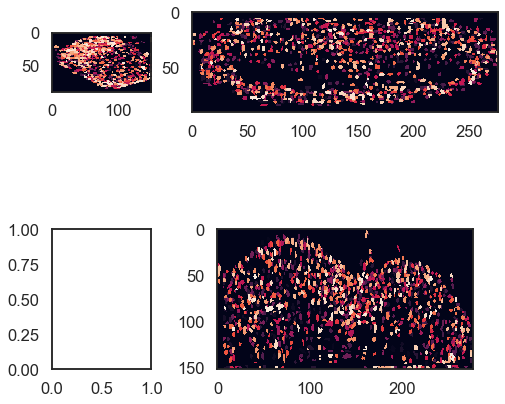

In [109]:
nC = np.shape(A)[1]
Ar = A*np.random.rand(nC,1)

dims = [int(i) for i in mat_contents['dims'].T]
R = np.reshape(Ar,dims, order='F')

f, ax = plt.subplots(2,2,gridspec_kw={'width_ratios':[dims[0]/dims[1],1],'height_ratios':[dims[1]/dims[2],1]},figsize=(8, 8))
ax[0,0].imshow(np.max(R,axis=1))
ax[0,1].imshow(np.max(R,axis=2))
ax[1,1].imshow(np.max(R,axis=0).T)
plt.show()

### what is the dimensionality of the data?

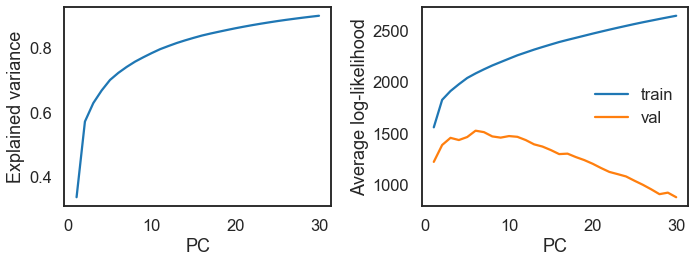

In [33]:
n_components = 30
ll_train = np.full(n_components, fill_value=np.nan)
ll_val = np.full(n_components, fill_value=np.nan)
for n in range(n_components):
    pca = PCA(n_components=n+1)
    pca.fit(data['train_all'])
    ll_train[n] = pca.score(data['train_all'])
    ll_val[n] = pca.score(data['val_all'])
    
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(np.arange(n_components)+1, np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('PC')
plt.ylabel('Explained variance')

plt.subplot(122)
plt.plot(np.arange(n_components)+1, ll_train, label='train')
plt.plot(np.arange(n_components)+1, ll_val, label='val')
plt.legend(frameon=False)
plt.xlabel('PC')
plt.ylabel('Average log-likelihood')

plt.tight_layout()
plt.show()

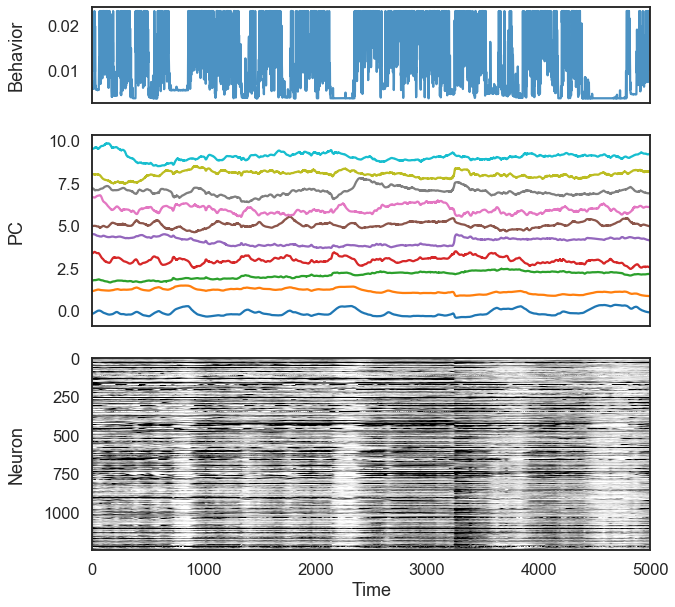

In [34]:
# plot pcs + neural activity
pca = PCA(n_components=10)
pca.fit(data['train_all'])
data_lowd = pca.transform(data_run)    
fig = plotting.plot_neural_activity(
    pcs=zscore(data_lowd), neural_data=data_run, behavior=behavior)

# 2. Fit dynamics

### ARHMM - start with 2 discrete states

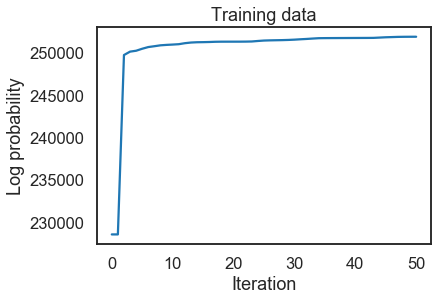

In [35]:
# first reduce dimensionality
data_pca_, data_pca = dataUtils.pca_reduce(data_run, 10, indxs, trial_len)

model_kwargs = {'transitions': 'standard', 'observations': 'ar'}
# model_kwargs = {'transitions': 'standard', 'observations': 'gaussian'}
arhmm = HMM(K=2, D=data_pca['train'][0].shape[1], M=0, **model_kwargs)
arhmm.initialize(data_pca['train'])
arhmm.observations.initialize(data_pca['train'])

# run EM; specify tolerances for overall convergence and each M-step's convergence
logprobs = arhmm.fit(
    datas=data_pca['train'], 
    method='em', num_em_iters=50, tolerance=1e-1,
    transitions_mstep_kwargs={'optimizer': 'lbfgs', 'tol': 1e-3})

plt.figure()
plt.plot(logprobs)
plt.ylabel('Log probability')
plt.xlabel('Iteration')
plt.title('Training data')
plt.show()

### how well do these states match behavior?

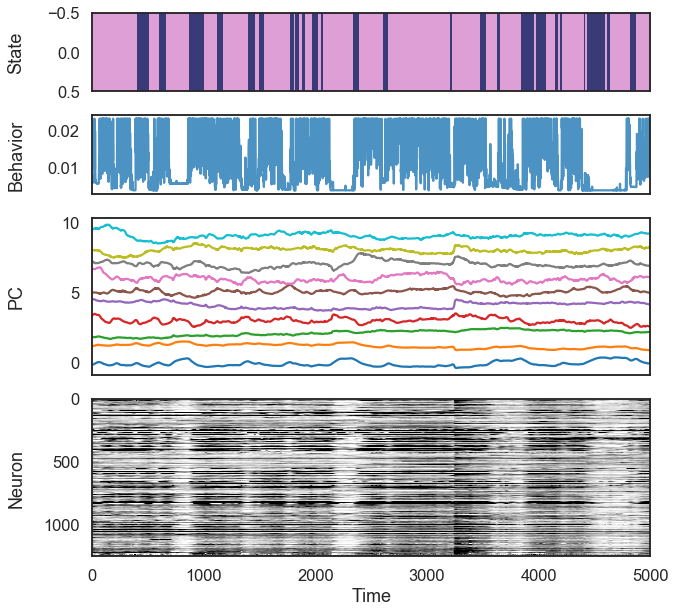

In [36]:
states_all = arhmm.most_likely_states(data_pca_)
# states_all = np.random.randint(1, 3, size=(data_pca_.shape[0], ))
fig = plotting.plot_neural_activity(
    pcs=zscore(data_lowd), neural_data=data_run, behavior=behavior, states=states_all)

### ARHMM - how many discrete states?

In [37]:
n_states = np.arange(1, 6)
D = data_pca['train'][0].shape[1]
model_kwargs = {
#     'hmm': {
#         'transitions': 'standard', 
#         'observations': 'gaussian'},
#     'arhmm': {
#         'transitions': 'standard', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 1}},
#     'arhmm-2': {
#         'transitions': 'standard', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 2}},
    'arhmm-3': {
        'transitions': 'standard', 
        'observations': 'ar',
        'observation_kwargs': {'lags': 3}},
    'arhmm-5': {
        'transitions': 'standard', 
        'observations': 'ar',
        'observation_kwargs': {'lags': 5}},
#     'arhmm-r': {
#         'transitions': 'recurrent', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 1}},
    'arhmm-r-3': {
        'transitions': 'recurrent', 
        'observations': 'ar',
        'observation_kwargs': {'lags': 3}},
    'arhmm-r-5': {
        'transitions': 'recurrent', 
        'observations': 'ar',
        'observation_kwargs': {'lags': 5}},
#     'arhmm-ro': {
#         'transitions': 'recurrent_only', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 1}},
    'arhmm-ro-3': {
        'transitions': 'recurrent_only', 
        'observations': 'ar',
        'observation_kwargs': {'lags': 3}},
    'arhmm-ro-5': {
        'transitions': 'recurrent_only', 
        'observations': 'ar',
        'observation_kwargs': {'lags': 5}},
}
all_results = {}
# iterate over model types
for model_name, kwargs in model_kwargs.items():
    model_results = {}
    # iterate over discrete states
    for K in n_states:
        print('Fitting %s with %i states' % (model_name, K))
        model_results[K] = utils.fit_model(
            n_states=K, data_dim=D, input_dim=0, model_kwargs=kwargs,
            data_tr=data_pca['train'], data_val=data_pca['val'], 
            data_test=data_pca['test'])
    all_results[model_name] = model_results

Fitting arhmm-3 with 1 states



Fitting arhmm-3 with 2 states



Fitting arhmm-3 with 3 states



Fitting arhmm-3 with 4 states



Fitting arhmm-3 with 5 states



Fitting arhmm-5 with 1 states



Fitting arhmm-5 with 2 states



Fitting arhmm-5 with 3 states



Fitting arhmm-5 with 4 states



Fitting arhmm-5 with 5 states



Fitting arhmm-r-3 with 1 states


/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depr


Fitting arhmm-r-3 with 2 states


/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depr


Fitting arhmm-r-3 with 3 states


/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depr


Fitting arhmm-r-3 with 4 states


/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depr


Fitting arhmm-r-3 with 5 states


/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depr


Fitting arhmm-r-5 with 1 states


/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depr


Fitting arhmm-r-5 with 2 states


/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depr


Fitting arhmm-r-5 with 3 states


/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depr


Fitting arhmm-r-5 with 4 states


/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depr


Fitting arhmm-r-5 with 5 states


/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depr


Fitting arhmm-ro-3 with 1 states


/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depr


Fitting arhmm-ro-3 with 2 states


/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depr


Fitting arhmm-ro-3 with 3 states


/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depr


Fitting arhmm-ro-3 with 4 states


/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depr


Fitting arhmm-ro-3 with 5 states


/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depr


Fitting arhmm-ro-5 with 1 states


/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depr


Fitting arhmm-ro-5 with 2 states


/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depr


Fitting arhmm-ro-5 with 3 states


/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depr


Fitting arhmm-ro-5 with 4 states


/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depr


Fitting arhmm-ro-5 with 5 states


/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depr

In [48]:
model_name = 'arhmm'
fig = plt.figure(figsize=(6, 5))
for K, model_result in all_results[model_name].items():
    plt.plot(model_result['lps'], label=str('K=%02i' % K))
plt.ylabel('Log probability')
plt.xlabel('Iteration')
plt.title('%s: Training data' % model_name.upper())
handles, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.0, 0.55), frameon=False)
plt.show()

KeyError: 'arhmm'

<Figure size 432x360 with 0 Axes>

In [ ]:
fig = plot_validation_likelihoods(
    all_results=all_results, 
    T_val=np.sum([d.shape[0] for d in data_pca['val']]))

### how well do these states match behavior?

In [ ]:
n_states = 3
model = all_results['arhmm-5'][n_states]['model']
states_all = model.most_likely_states(data_pca_)

In [ ]:
fig = plot_neural_activity(
    pcs=zscore(data_lowd), neural_data=data_run, behavior=behavior, states=states_all,
    slc=(2500, 3500))

In [ ]:
plt.figure(figsize=(10, 4))
    
# color PCs by time
plt.subplot(121)
plot_pcs(proj, color=np.arange(proj.shape[0]))
cbar = plt.colorbar()
cbar.ax.set_title('Time')

# color PCs by discrete state
plt.subplot(122)
plot_pcs(proj, color=model.most_likely_states(data_pca_), cmap='tab10')
cbar = plt.colorbar()
cbar.ax.set_title('State')
plt.tight_layout()
plt.show()

In [ ]:
# plot state transition matrix
trans = np.copy(model.transitions.transition_matrix)
deridge = False
if deridge:
    n_states = trans.shape[0]
    for i in range(n_states):
        trans[i, i] = np.nan
    clim = np.nanmax(np.abs(trans))
else:
    clim = 1
plt.figure()
plt.imshow(trans, clim=[-clim, clim], cmap='RdBu_r')
plt.colorbar()
plt.title('State transition matrix')
plt.show()

In [ ]:
fig = plot_dynamics_matrices(model, deridge=False)

# 3. Fit dynamics on subsets of cells

### plot raster of PCA reconstructions

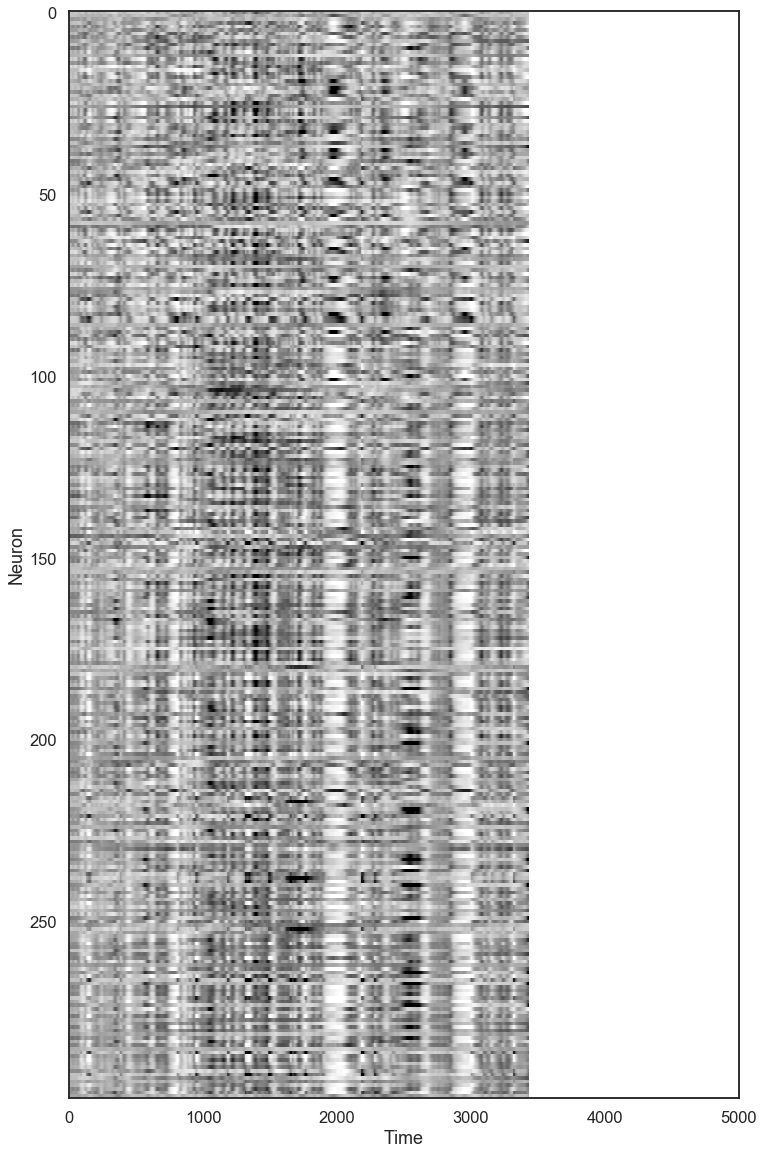

In [51]:
pca = PCA(n_components=10)
pca.fit(data['train_all'])
data_run_recon = pca.inverse_transform(pca.transform(data_run))

slc = (0, 5000)
vmin = np.quantile(data_run[slice(*slc)], 0.01)
vmax = np.quantile(data_run[slice(*slc)], 0.99)
plt.figure(figsize=(12, 20))
plt.imshow(
    data_run_recon[slice(*slc), :].T, aspect='auto', 
    cmap='Greys', vmin=vmin, vmax=vmax)
plt.xlim(0, slc[1] - slc[0])
plt.xlabel('Time')
plt.ylabel('Neuron')
plt.show()

### plot raster of cell activities

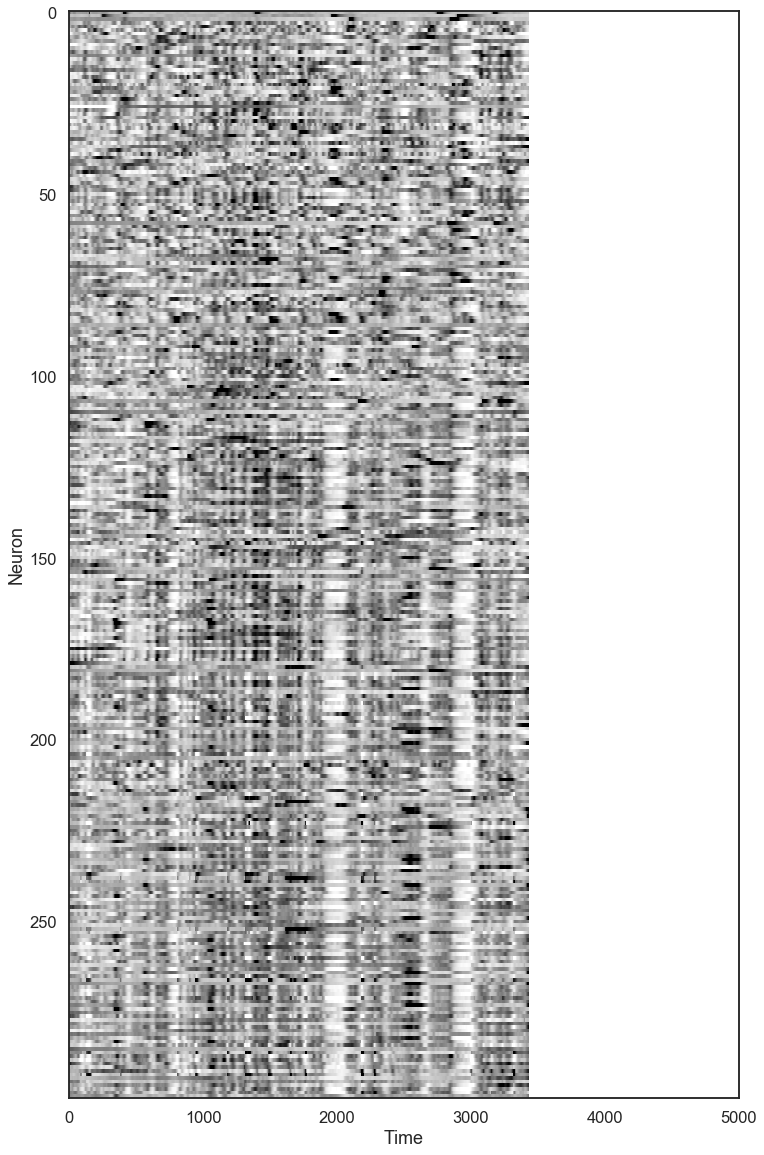

In [52]:
slc = (0, 5000)
vmin = np.quantile(data_run[slice(*slc)], 0.01)
vmax = np.quantile(data_run[slice(*slc)], 0.99)
plt.figure(figsize=(12, 20))
plt.imshow(
    data_run[slice(*slc), :].T, aspect='auto', 
    cmap='Greys', vmin=vmin, vmax=vmax)
plt.xlim(0, slc[1] - slc[0])
plt.xlabel('Time')
plt.ylabel('Neuron')
plt.show()

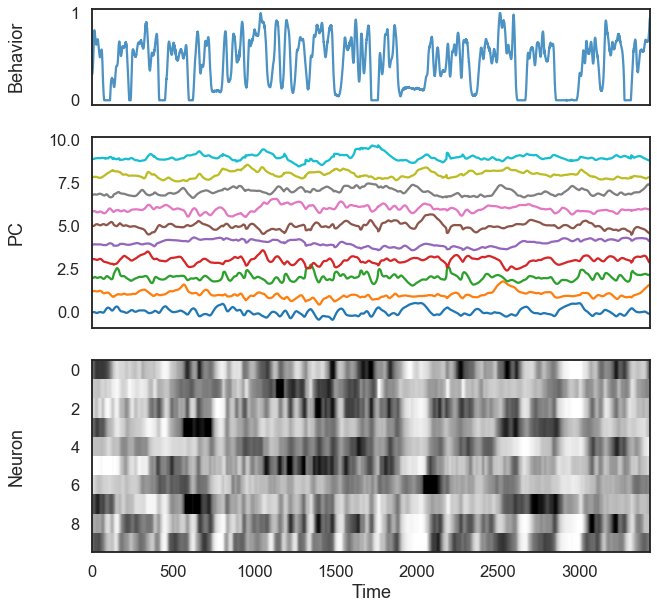

In [56]:
# plot pcs + neural activity
pca = PCA(n_components=10)
pca.fit(data['train_all'])
data_lowd = pca.transform(data_run)    
cell_indxs = np.arange(130, 140)
fig = plotting.plot_neural_activity(
    pcs=zscore(data_lowd), neural_data=data_run[:, cell_indxs], behavior=behavior)

### sub-population: 2 states

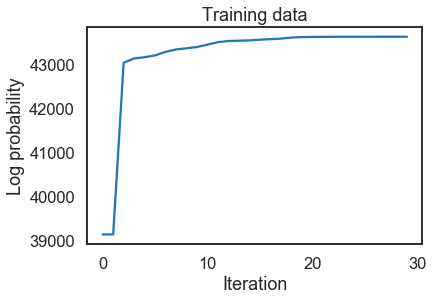

In [58]:
# first subsample cells
# cell_indxs = np.arange(205, 220)
cell_indxs = np.arange(130, 140)
data_sub_, data_sub = dataUtils.subsample_cells(data_run, cell_indxs, indxs, trial_len)

model_kwargs = {'transitions': 'standard', 'observations': 'ar'}

arhmm = HMM(K=2, D=data_sub['train'][0].shape[1], M=0, **model_kwargs)
arhmm.initialize(data_sub['train'])
arhmm.observations.initialize(data_sub['train'])

# run EM; specify tolerances for overall convergence and each M-step's convergence
logprobs = arhmm.fit(
    datas=data_sub['train'], 
    method='em', num_em_iters=50, tolerance=1e-1,
    transitions_mstep_kwargs={'optimizer': 'lbfgs', 'tol': 1e-3})

plt.figure()
plt.plot(logprobs)
plt.ylabel('Log probability')
plt.xlabel('Iteration')
plt.title('Training data')
plt.show()

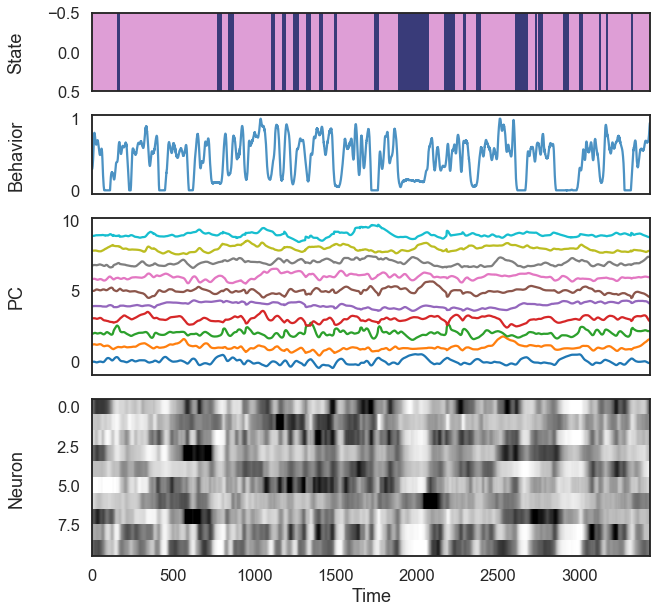

In [60]:
states_all = arhmm.most_likely_states(data_sub_)
# states_all = np.random.randint(1, 3, size=(data_pca_.shape[0], ))
fig = plotting.plot_neural_activity(
    pcs=zscore(data_lowd), neural_data=data_sub_, behavior=behavior, states=states_all)

In [54]:
n_states = np.arange(1, 7)
D = data_sub['train'][0].shape[1]
model_kwargs = {
    'hmm': {
        'transitions': 'standard', 
        'observations': 'gaussian'},
    'arhmm': {
        'transitions': 'standard', 
        'observations': 'ar',
        'observation_kwargs': {'lags': 1}},
#     'arhmm-2': {
#         'transitions': 'standard', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 2}},
#     'arhmm-3': {
#         'transitions': 'standard', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 3}},
#     'arhmm-5': {
#         'transitions': 'standard', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 5}},
    'arhmm-r': {
        'transitions': 'recurrent', 
        'observations': 'ar',
        'observation_kwargs': {'lags': 1}},
#     'arhmm-r-3': {
#         'transitions': 'recurrent', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 3}},
#     'arhmm-r-5': {
#         'transitions': 'recurrent', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 5}},
    'arhmm-ro': {
        'transitions': 'recurrent_only', 
        'observations': 'ar',
        'observation_kwargs': {'lags': 1}},
#     'arhmm-ro-3': {
#         'transitions': 'recurrent_only', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 3}},
#     'arhmm-ro-5': {
#         'transitions': 'recurrent_only', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 5}},
}
all_results = {}
# iterate over model types
for model_name, kwargs in model_kwargs.items():
    model_results = {}
    # iterate over discrete states
    for K in n_states:
        print('Fitting %s with %i states' % (model_name, K))
        model_results[K] = fit_model(
            n_states=K, data_dim=D, input_dim=0, model_kwargs=kwargs,
            data_tr=data_sub['train'], data_val=data_sub['val'], 
            data_test=data_sub['test'])
    all_results[model_name] = model_results

Fitting hmm with 1 states


Fitting hmm with 2 states


Fitting hmm with 3 states


Fitting hmm with 4 states


Fitting hmm with 5 states


Fitting hmm with 6 states


Fitting arhmm with 1 states


Fitting arhmm with 2 states


Fitting arhmm with 3 states


Fitting arhmm with 4 states


Fitting arhmm with 5 states


Fitting arhmm with 6 states


Fitting arhmm-r with 1 states


/home/mattw/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/home/mattw/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/home/mattw/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In t

Fitting arhmm-r with 2 states


Fitting arhmm-r with 3 states


Fitting arhmm-r with 4 states


Fitting arhmm-r with 5 states


Fitting arhmm-r with 6 states


Fitting arhmm-ro with 1 states


Fitting arhmm-ro with 2 states


Fitting arhmm-ro with 3 states


Fitting arhmm-ro with 4 states


Fitting arhmm-ro with 5 states


Fitting arhmm-ro with 6 states


In [61]:
import copy
all_results_ = copy.copy(all_results)
# _ = all_results_.pop('hmm')
_ = all_results_.pop('arhmm')
_ = all_results_.pop('arhmm-r')
_ = all_results_.pop('arhmm-ro')
fig = plot_validation_likelihoods(
    all_results=all_results_, 
    T_val=np.sum([d.shape[0] for d in data_sub['val']]))

KeyError: 'arhmm'

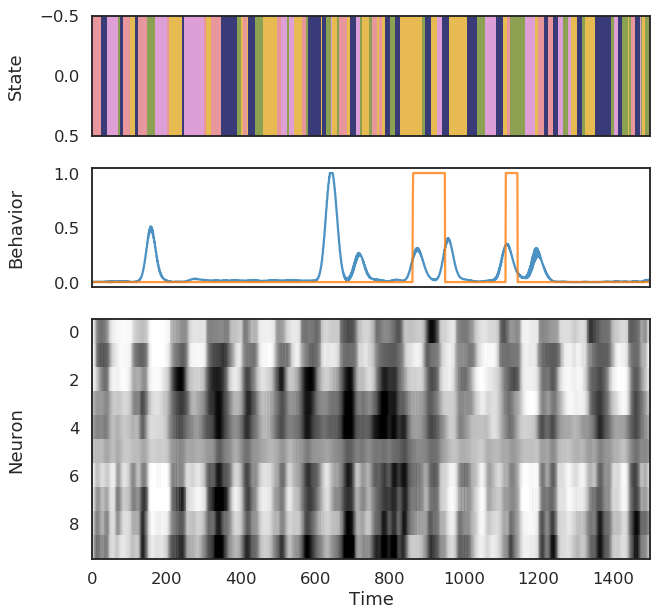

In [95]:
n_states = 5
model = all_results['arhmm'][n_states]['model']
states_all = model.most_likely_states(data_sub_)

# fig = plot_neural_activity(
#     pcs=zscore(data_lowd), neural_data=data_sub_, behavior=behavior, states=states_all,
#     slc=(2000, 3500))
fig = plot_neural_activity(
    pcs=None, neural_data=data_sub_, behavior=behavior, states=states_all,
    slc=(2000, 3500))

## Notes
<br>

* In C. elegans, neural circuits that respond to appetitive cues alter transition probabilities between a core set of locomotor-related behavioral modules, thereby creating new behavioral sequences that enable taxis toward attractive odorants